In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings('ignore')

In [3]:
def extract_features(audio_path, sample_rate=22050):
    audio, sr = librosa.load(audio_path, sr=sample_rate, mono=True)
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)  # Convert to mono
    # MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfccs_mean = mfccs.mean(axis=1)
    mfccs_std = mfccs.std(axis=1)
    # Delta MFCCs
    delta_mfccs = librosa.feature.delta(mfccs)
    delta_mfccs_mean = delta_mfccs.mean(axis=1)
    delta_mfccs_std = delta_mfccs.std(axis=1)
    # Chroma
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    chroma_mean = chroma.mean(axis=1)
    chroma_std = chroma.std(axis=1)
    # Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    contrast_mean = contrast.mean(axis=1)
    contrast_std = contrast.std(axis=1)
    # Tonnetz
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr)
    tonnetz_mean = tonnetz.mean(axis=1)
    tonnetz_std = tonnetz.std(axis=1)
    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(audio)
    zcr_mean = zcr.mean()
    zcr_std = zcr.std()
    # Root Mean Square Energy
    rms = librosa.feature.rms(y=audio)
    rms_mean = rms.mean()
    rms_std = rms.std()
    # Spectral Centroid
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    centroid_mean = centroid.mean()
    centroid_std = centroid.std()
    # Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    rolloff_mean = rolloff.mean()
    rolloff_std = rolloff.std()
    # Combine all features
    features = np.hstack([
        mfccs_mean, mfccs_std,
        delta_mfccs_mean, delta_mfccs_std,
        chroma_mean, chroma_std,
        contrast_mean, contrast_std,
        tonnetz_mean, tonnetz_std,
        [zcr_mean, zcr_std, rms_mean, rms_std, centroid_mean, centroid_std, rolloff_mean, rolloff_std]
    ])
    return features

def get_emotion_from_filename(filename):
    emotions = {
        '01': 'neutral',
        '02': 'calm',
        '03': 'happy',
        '04': 'sad',
        '05': 'angry',
        '06': 'fearful',
        '07': 'disgust',
        '08': 'surprised'
    }
    emotion_code = filename.split('-')[2]
    return emotions.get(emotion_code, 'unknown')

In [4]:
data_dir = '/content/drive/MyDrive/SPS_Project_emotion/data/RAVDESS' # Adjust if your path is different
features = []
emotions = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            try:
                feat = extract_features(file_path)
                features.append(feat)
                emotions.append(get_emotion_from_filename(file))
            except Exception as e:
                print(f'Error processing {file}: {e}')

features = np.array(features)
emotions = np.array(emotions)
print(f'Loaded {len(features)} samples.')

Loaded 1440 samples.


In [6]:
le = LabelEncoder()
labels_encoded = le.fit_transform(emotions)
labels_onehot = to_categorical(labels_encoded)

X_train, X_test, y_train, y_test = train_test_split(
    features, labels_onehot, test_size=0.2, random_state=42, stratify=labels_onehot
)
print('Train samples:', X_train.shape[0], 'Test samples:', X_test.shape[0])

Train samples: 1152 Test samples: 288


In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
from sklearn.utils.class_weight import compute_class_weight

num_classes = y_train.shape[1]
input_shape = X_train_scaled.shape[1]

model = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(input_shape,)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.2119 - loss: 2.5708 - val_accuracy: 0.4340 - val_loss: 1.6565
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4223 - loss: 1.6338 - val_accuracy: 0.4861 - val_loss: 1.4488
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4856 - loss: 1.3960 - val_accuracy: 0.5556 - val_loss: 1.2956
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5719 - loss: 1.1505 - val_accuracy: 0.5764 - val_loss: 1.2346
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6576 - loss: 0.9693 - val_accuracy: 0.5903 - val_loss: 1.1376
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6668 - loss: 0.9115 - val_accuracy: 0.6181 - val_loss: 1.0976
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7182 - loss: 0.8343 - val_accuracy: 0.6458 - val_loss: 1.0599
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7333 - loss: 0.6972 - val_accuracy: 0.6458 - v

In [9]:
# Save model
model.save('/content/drive/MyDrive/SPS_Project_emotion/models/emotion_model.h5')

# Save scaler
import pickle
with open('/content/drive/MyDrive/SPS_Project_emotion/models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

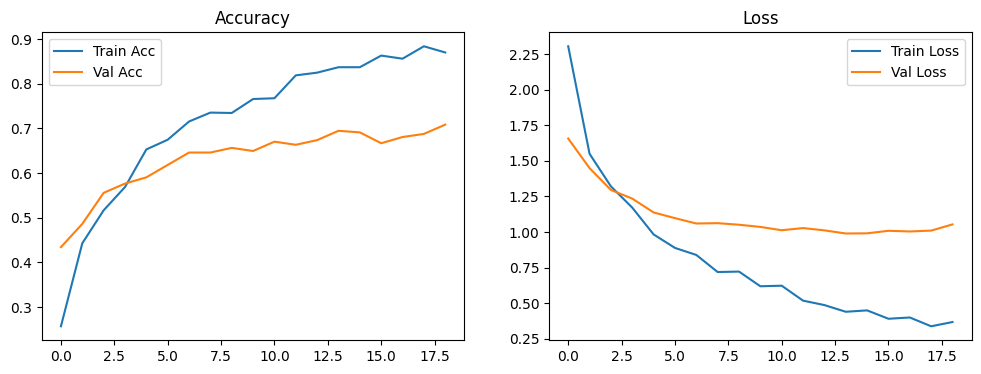

In [10]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [11]:
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Test accuracy: {test_acc:.2%}')

Test accuracy: 69.44%


In [12]:
print(le.classes_)

['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


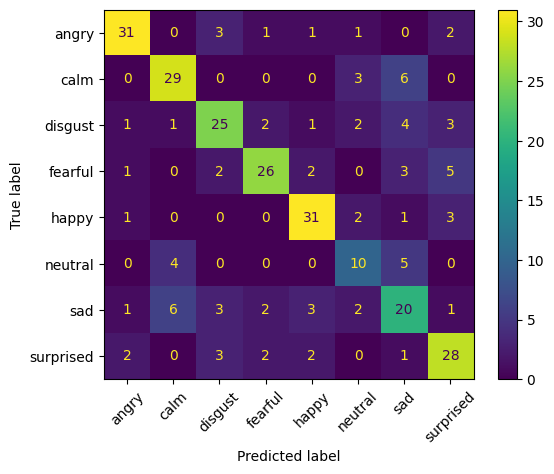

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test_scaled)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45)
plt.show()

**Another Model**

In [14]:
def extract_mfcc_sequence(audio_path, sample_rate=22050, n_mfcc=40, max_pad_len=174):
    audio, sr = librosa.load(audio_path, sr=sample_rate)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    # Pad or truncate to fixed length
    if mfcc.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    return mfcc

In [15]:
# Extract MFCC sequences for all files
X_seq = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            try:
                mfcc_seq = extract_mfcc_sequence(file_path)
                X_seq.append(mfcc_seq)
            except Exception as e:
                print(f'Error processing {file}: {e}')
X_seq = np.array(X_seq)
# X_seq shape: (num_samples, n_mfcc, max_pad_len)

In [16]:
from sklearn.model_selection import train_test_split

X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(
    X_seq, labels_onehot, test_size=0.2, random_state=42, stratify=labels_onehot
)

In [17]:
from tensorflow.keras import layers, models

input_shape = (X_seq.shape[1], X_seq.shape[2], 1)  # (n_mfcc, max_pad_len, 1)
X_seq = X_seq[..., np.newaxis]  # Add channel dimension

cnn_lstm_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Reshape((-1, 64)),  # Flatten spatial dims, keep time for LSTM
    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 172, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 38, 172, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 84, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 17, 84, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 336, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,904 (222.28 KB)

 Trainable params: 56,712 (221.53 KB)

 Non-trainable params: 192 (768.00 B)

In [18]:
history_cnn_lstm = cnn_lstm_model.fit(
    X_seq_train, y_seq_train,
    validation_data=(X_seq_test, y_seq_test),
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    ]
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 657ms/step - accuracy: 0.1542 - loss: 2.0958 - val_accuracy: 0.1701 - val_loss: 2.0903
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 582ms/step - accuracy: 0.1267 - loss: 2.0793 - val_accuracy: 0.1736 - val_loss: 2.0537
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 663ms/step - accuracy: 0.1649 - loss: 2.0374 - val_accuracy: 0.2396 - val_loss: 2.0115
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 576ms/step - accuracy: 0.1926 - loss: 2.0068 - val_accuracy: 0.1736 - val_loss: 2.0125
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 43s 640ms/step - accuracy: 0.2426 - loss: 1.9595 - val_accuracy: 0.2812 - val_loss: 1.8655
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 44s 708ms/step - accuracy: 0.2935 - loss: 1.8746 - val_accuracy: 0.2882 - val_loss: 1.8143
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 643ms/step - accuracy: 0.2954 - loss: 1.8440 - val_accuracy: 0.2778 - val_loss: 1.8565
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 618ms/step - accuracy: 0.2857 - loss: 1.8155 - val_accu

Test accuracy: 45.49%
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step


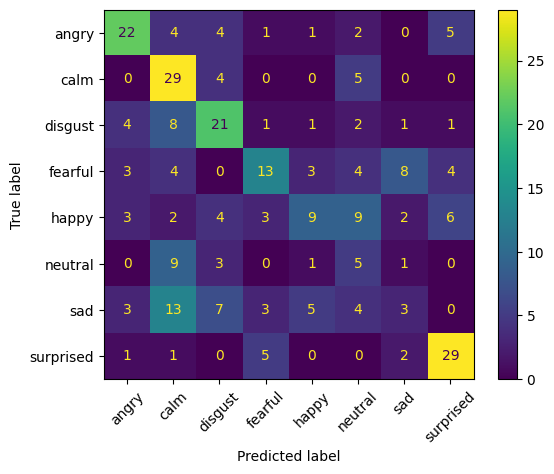

In [19]:
# Evaluate the CNN+LSTM model on the test set and plot the confusion matrix

# Evaluate test accuracy and loss
test_loss, test_acc = cnn_lstm_model.evaluate(X_seq_test, y_seq_test, verbose=0)
print(f"Test accuracy: {test_acc:.2%}")

# Predict on the test set
y_pred_probs = cnn_lstm_model.predict(X_seq_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_seq_test, axis=1)

# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45)
plt.show()

**figures**

tets metricies for CNN+LSTM and DNN

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# --- For DNN ---
# Evaluate test accuracy and loss
test_loss_dnn, test_acc_dnn = model.evaluate(X_test_scaled, y_test, verbose=0)

# Predict on the test set for DNN
y_pred_dnn = model.predict(X_test_scaled)
y_pred_labels_dnn = np.argmax(y_pred_dnn, axis=1)
y_true_labels_dnn = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1-score for DNN
precision_dnn = precision_score(y_true_labels_dnn, y_pred_labels_dnn, average='weighted')
recall_dnn = recall_score(y_true_labels_dnn, y_pred_labels_dnn, average='weighted')
f1_dnn = f1_score(y_true_labels_dnn, y_pred_labels_dnn, average='weighted')

# Print DNN metrics
print("DNN Metrics:")
print(f"Test Accuracy: {test_acc_dnn:.2%}")
print(f"Precision: {precision_dnn:.2%}")
print(f"Recall: {recall_dnn:.2%}")
print(f"F1-Score: {f1_dnn:.2%}")

# --- For CNN+LSTM ---
# Evaluate test accuracy and loss
test_loss_cnn_lstm, test_acc_cnn_lstm = cnn_lstm_model.evaluate(X_seq_test, y_seq_test, verbose=0)

# Predict on the test set for CNN+LSTM
y_pred_cnn_lstm = cnn_lstm_model.predict(X_seq_test)
y_pred_labels_cnn_lstm = np.argmax(y_pred_cnn_lstm, axis=1)
y_true_labels_cnn_lstm = np.argmax(y_seq_test, axis=1)

# Calculate precision, recall, and F1-score for CNN+LSTM
precision_cnn_lstm = precision_score(y_true_labels_cnn_lstm, y_pred_labels_cnn_lstm, average='weighted')
recall_cnn_lstm = recall_score(y_true_labels_cnn_lstm, y_pred_labels_cnn_lstm, average='weighted')
f1_cnn_lstm = f1_score(y_true_labels_cnn_lstm, y_pred_labels_cnn_lstm, average='weighted')

# Print CNN+LSTM metrics
print("\nCNN+LSTM Metrics:")
print(f"Test Accuracy: {test_acc_cnn_lstm:.2%}")
print(f"Precision: {precision_cnn_lstm:.2%}")
print(f"Recall: {recall_cnn_lstm:.2%}")
print(f"F1-Score: {f1_cnn_lstm:.2%}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
DNN Metrics:
Test Accuracy: 69.44%
Precision: 69.90%
Recall: 69.44%
F1-Score: 69.54%
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step

CNN+LSTM Metrics:
Test Accuracy: 45.49%
Precision: 44.96%
Recall: 45.49%
F1-Score: 43.46%


Training and Validation Accuracy/Loss Curves




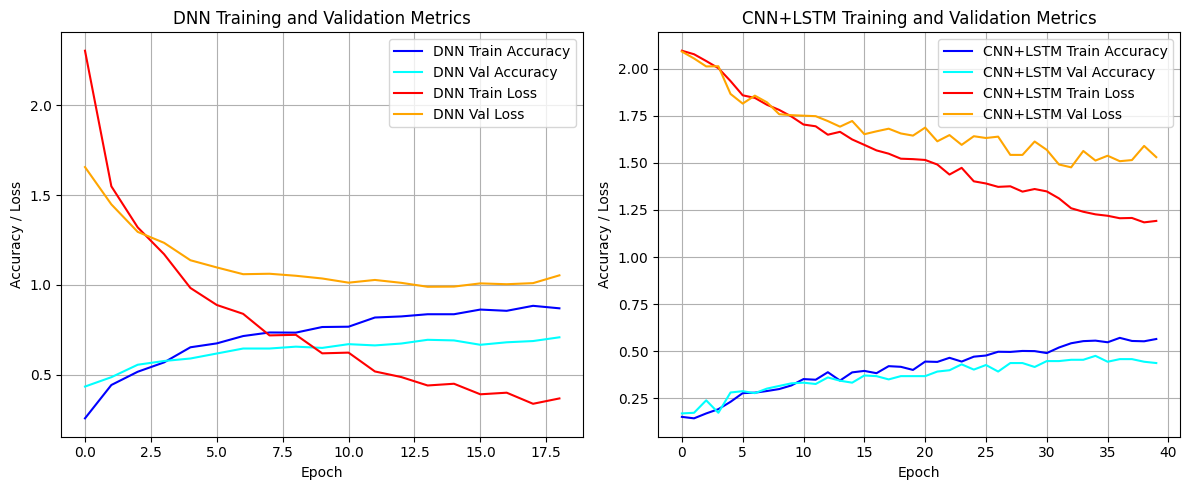

In [25]:
import matplotlib.pyplot as plt

# history is from DNN training, history_cnn_lstm is from CNN+LSTM training

plt.figure(figsize=(12, 5))

# DNN Accuracy and Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='DNN Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='DNN Val Accuracy', color='cyan')
plt.plot(history.history['loss'], label='DNN Train Loss', color='red')
plt.plot(history.history['val_loss'], label='DNN Val Loss', color='orange')
plt.title('DNN Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.grid(True)

# CNN+LSTM Accuracy and Loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn_lstm.history['accuracy'], label='CNN+LSTM Train Accuracy', color='blue')
plt.plot(history_cnn_lstm.history['val_accuracy'], label='CNN+LSTM Val Accuracy', color='cyan')
plt.plot(history_cnn_lstm.history['loss'], label='CNN+LSTM Train Loss', color='red')
plt.plot(history_cnn_lstm.history['val_loss'], label='CNN+LSTM Val Loss', color='orange')
plt.title('CNN+LSTM Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_validation_curves.png')

Confusion Matrices for DNN and CNN+LSTM

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


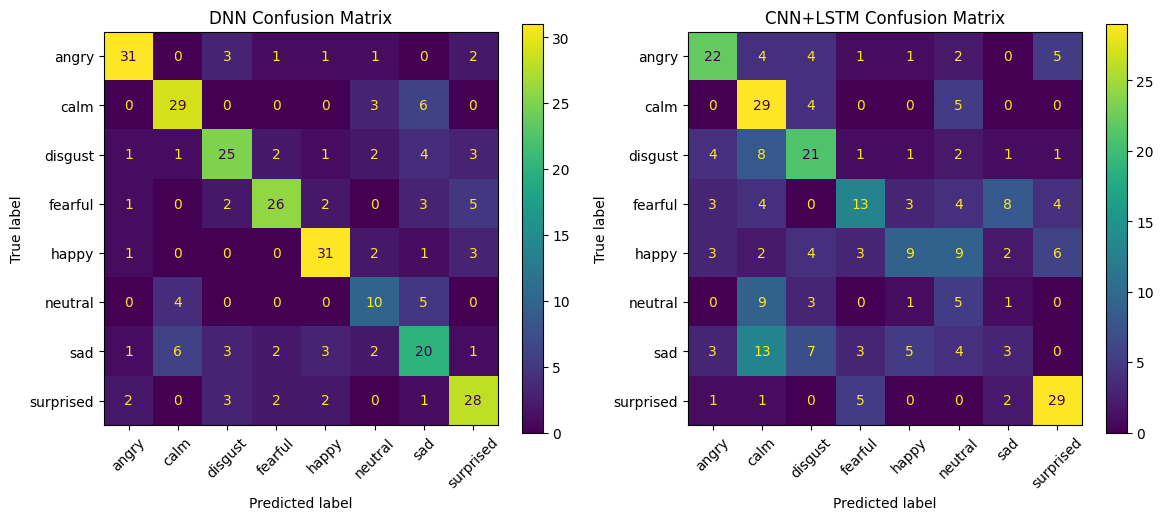

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- For DNN ---
# Predict on the test set for DNN
y_pred_dnn = model.predict(X_test_scaled)
y_pred_labels_dnn = np.argmax(y_pred_dnn, axis=1)
y_true_labels_dnn = np.argmax(y_test, axis=1)

# --- For CNN+LSTM ---
# Predict on the test set for CNN+LSTM
y_pred_cnn_lstm = cnn_lstm_model.predict(X_seq_test)
y_pred_labels_cnn_lstm = np.argmax(y_pred_cnn_lstm, axis=1)
y_true_labels_cnn_lstm = np.argmax(y_seq_test, axis=1)

# Create confusion matrices
cm_dnn = confusion_matrix(y_true_labels_dnn, y_pred_labels_dnn)
cm_cnn_lstm = confusion_matrix(y_true_labels_cnn_lstm, y_pred_labels_cnn_lstm)

# Plotting
plt.figure(figsize=(12, 5))

# DNN Confusion Matrix
plt.subplot(1, 2, 1)
disp_dnn = ConfusionMatrixDisplay(confusion_matrix=cm_dnn, display_labels=le.classes_)
disp_dnn.plot(xticks_rotation=45, ax=plt.gca())
plt.title('DNN Confusion Matrix')

# CNN+LSTM Confusion Matrix
plt.subplot(1, 2, 2)
disp_cnn_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_cnn_lstm, display_labels=le.classes_)
disp_cnn_lstm.plot(xticks_rotation=45, ax=plt.gca())
plt.title('CNN+LSTM Confusion Matrix')

plt.tight_layout()
plt.savefig('confusion_matrices.png')